In [1]:
import numpy as np

import matplotlib.pyplot as plt

microm2m = 1.0E-6
m2microm = 1.0E6

In [2]:
import numpy as np
import math

from numpy import linspace, zeros, array, pi, sin, cos, exp, arange
from scipy.fftpack import fft, ifft, dct, idct, dst, idst, fftshift, fftfreq

from math import sqrt
from skimage import data
from skimage.feature import blob_log


import matplotlib.pyplot as plt

from apsg import *





def cartesian_components(D, I, Q, R):
    
    """
    Calculates the cartesian components of  natural remanent magnetization (NRM)
    for uniformily magnetized spheres (mx, my, mz) required in the forward model.

    Parameters:
        * D: 1D-array containing magnetization declination (0 to 360 degrees)
        * I: 1D-array containing magnetization inclination (-90 to 90  degress)
        * Q: 1D-array containing magnetization intensity (A/m)
        * R: 1D-array containing sphere's radius (m)

    Constant:
        * cm: is a constant given by 4*np.pi/µo = 10**(-7) 
            where µo is the vaccum magnetic permeability
    """
    
    
    cm = 10**(-7) # H/m  == T·m/A
    m = []

    for i in range(np.size(D)):
        m_sphere =  np.matrix([[(Q[i]*np.cos(I[i]*(np.pi/180))*np.cos(D[i]*(np.pi/180))) * ((cm*4.0*np.pi*R[i]**3)/3.0) ],
                          [(Q[i]*np.cos(I[i]*(np.pi/180))*np.sin(D[i]*(np.pi/180))) * ((cm*4.0*np.pi*R[i]**3)/3.0) ],
                           [(Q[i]*np.sin(I[i]*(np.pi/180)))*((cm*4.0*np.pi*R[i]**3)/3.0)                            ]])

        m = np.append(m,m_sphere)
        
    return(np.array(m))



def sensibility_matrix(X, Y, Z, Xc, Yc, Zc): 
    
    """
    Generates the sensibility matrix for vertical component of magnetization

    Parameters:
        *  X,  Y,  Z: 1D-arrays with x, y and z data positions
        * Xc, Yc, Zc: 1D-arrays with x, y and z data  of the sphere's center positions
    """

    dzz = np.zeros(np.shape(Z))
    dxz = np.zeros(np.shape(Z))
    dzy = np.zeros(np.shape(Z))


    for j in range(len(Xc)):
        for i in range(len(X)):
            dzz[i] =  -1.0*( (X[i]-Xc[j])**2+(Y[i]-Yc[j])**2-2*(Z[i]-Zc[j])**2) / (  ((X[i]-Xc[j])**2+(Y[i]-Yc[j])**2+(Z[i]-Zc[j])**2) )**(5/2)
            dxz[i] = ( 3.0*(X[i]-Xc[j])*(Z[i]-Zc[j]) ) / (  ((X[i]-Xc[j])**2+(Y[i]-Yc[j])**2+(Z[i]-Zc[j])**2) )**(5/2)
            dzy[i] = ( 3.0*(Z[i]-Zc[j])*(Y[i]-Yc[j]) ) / (  ((X[i]-Xc[j])**2+(Y[i]-Yc[j])**2+(Z[i]-Zc[j])**2) )**(5/2)
            
        M = ([[dxz],[dzy],[dzz]])
        
        M = np.reshape(M, (3, np.size(dzz)))
        M.T
        
        if j==0:
            Mz = np.copy(M)
        else:
            Mz = np.concatenate((Mz,M), axis=0)


    return(Mz.T) # sensibility matrix                    
    


def regular(area, shape, z=None):
    
    """
    Generates the regular grid --> source https://legacy.fatiando.org/cookbook.html

    Parameters:
        * area: array with x axis size (nx) and y axis size (ny)
        * shape: array with min(x), max(x), min(y) and max(y)
        * z: float with the distance between the sample surface and the sensor
    """
    
    nx, ny = shape
    x1, x2, y1, y2 = area
    xs = np.linspace(x1, x2, nx)
    ys = np.linspace(y1, y2, ny)
    
    arrays = np.meshgrid(ys, xs)[::-1]
    
    if z is not None:
        arrays.append(z*np.ones(nx*ny, dtype=np.float64))
    return [i.ravel() for i in arrays]



def noise(d, error=0.05):
    
    """
    Generates a Gaussian noise (normal distribution, mean equals zero, and desv. pad. equals the error percent input)

    Parameters:
        * d: simulated data vector
        * percent_erro: error percentage (default = 5%) based on the maximum amplitude of the anomaly 

    """
    
    sigma_noise = (np.absolute(np.max(d))+np.absolute(np.min(d))) * error
    delta_d = np.array(np.random.normal(0,sigma_noise,len(d)))
    delta_D = np.transpose(delta_d)

    d_noise = d+delta_D
 
    return (d_noise)





def y_derivative_fft(d_, Y_): 
    
    ddy = np.zeros(np.shape(d_))
    ky = np.zeros(np.shape(d_))

    # y derivative
    for i in range(np.shape(d_)[0]):
        Ny = np.size(d_[i,:])
        y = Y_[i,:]
        dy = y[1]-y[0]

        fy = d_[i,:]
        k = fftfreq(Ny,dy)

        derivative_y   = np.real(ifft(2*pi*k*1j*fft(fy)))

        ddy[i,:] = derivative_y
        ky[i,:] = k
    
    return(ddy, ky)




def x_derivative_fft(d_, X_):
    ddx = np.zeros(np.shape(d_))
    kx = np.zeros(np.shape(d_))
    
    # x derivative 
    for j in range(np.shape(d_)[1]):
        Nx = np.size(d_[:,j])
        x = np.transpose(X_[:,j])
        dx = x[1]-x[0]

        fx = np.transpose(d_[:,j])
        k = fftfreq(Nx,dx)

        derivative_x   = np.real(ifft(2*pi*k*1j*fft(fx)))

        ddx[:,j] = derivative_x
        kx[:,j] = k
        
    return(ddx, kx)




def z_derivative_fft(d, kx, ky):
    
    # derivative Z
    kx_ = np.reshape(kx,   (1,int(np.size(kx))))
    ky_ = np.reshape(ky.T, (1,int(np.size(ky))))
    
    kz = np.absolute(np.sqrt(kx_**2+ky_**2))
    kz_ = np.reshape(kz, (1,int(np.size(kz))))
    
    kz = np.absolute(np.sqrt(kx_**2+ky_**2))
    kz_ = np.reshape(kz, (1,int(np.size(kz))))

    #ddz = np.zeros(np.shape(d))
    fz = np.reshape(d, (1,int(np.size(d)))) #np.transpose(d)
    #fz = d
    derivative_z = np.real(ifft((np.absolute(2*pi*kz_))*fft(fz)))

    ddz = derivative_z
    ddz = np.reshape(ddz, np.shape(kx))
    
    return(ddz)




def derivative_fd(vertical_field,X,Y):
    derivative_X=np.zeros(np.shape(vertical_field))
    derivative_Y=np.zeros(np.shape(vertical_field))
    
    for j in range(np.shape(X)[1]-1):
        for i in range(np.shape(Y)[0]-1):
            derivative_X[i,j]=np.array((vertical_field[i+1,j]-vertical_field[i-1,j])/(X[i+1,j]-X[i-1,j]))
            derivative_Y[i,j]=np.array((vertical_field[i, j+1]-vertical_field[i,j-1])/(Y[i,j+1]-Y[i,j-1]))
    derivative_X[0,:] = derivative_X[1,:]
    derivative_X[-1,:] = derivative_X[-2,:]
    derivative_Y[:,0] = derivative_Y[:,1]
    derivative_Y[:,-1] = derivative_Y[:,-2]
    
    
    return(derivative_X, derivative_Y)



def Horiz_Grad(DX, DY): 
    
    HG = np.sqrt(np.absolute(DY**2+DX**2))
    
    return(HG)


def upward_continuation(d_, delta_z, kx, ky):
                     
    
    kx_ = np.reshape(kx, (1,int(np.size(kx))))
    ky_ = np.reshape(ky.T,(1,int(np.size(ky))))
    
    kz = np.absolute(np.sqrt(kx_**2+ky_**2))
    kz_ = np.reshape(kz, (1,int(np.size(kz))))
    
    
    f = (np.reshape(d_, (1,int(np.size(d_)))))
    #f = d_
    fhat = fft(f)
    
    up_cont_factor = np.exp((delta_z)*(2*pi*kz_))
    
    up_cont = np.real(ifft(fhat*up_cont_factor))   
    up_cont = np.reshape(up_cont, np.shape(kx))
    
    print(np.shape(up_cont))
    
    up_cont[0,:] = up_cont[1,:]
    up_cont[-1,:] = up_cont[-2,:]
    up_cont[:,0] = up_cont[:,1]
    up_cont[:,-1] = up_cont[:,-2]
    
    return(up_cont)


def z_derivative_fd(upward_1, upward_2, delta_Z1, delta_Z2):
    derivative_Z = np.zeros(np.shape(upward_1))
        
    for i in range(np.shape(upward_1)[0]-1):
        for j in range(np.shape(upward_1)[1]-1):
            derivative_Z[i,j]=np.array((upward_1[i,j]-upward_2[i,j])/(np.absolute(delta_Z2 - delta_Z1)))
    
    return(derivative_Z)



def sources_finder(Horiz_Grad, threshold=.05, data = []):
        
    input_data = (Horiz_Grad / Horiz_Grad.max())  # normalizando o dado entrada (0<= dado <=1)
    
    amp_0 = int(0.2*np.size(input_data[0]))
    amp_1 = int(0.2*np.size(input_data[0]))
    amp_0_f = int(amp_0/2)
    amp_1_f = int(amp_1/2)
    mean = np.mean(input_data)
    input_data_amplified = np.ones( (np.shape(input_data)[0]+amp_0, np.shape(input_data)[1]+amp_1 ) ) * mean
    
    for j in range(np.shape(input_data)[1]):
        for i in range(np.shape(input_data)[0]):
            input_data_amplified[i+amp_0_f,j+amp_1_f] = input_data[i,j]

    input_data_amplified = (input_data_amplified / input_data_amplified.max())
    
    blobs_log = blob_log(input_data_amplified, min_sigma=2, max_sigma=100, num_sigma=100, threshold = threshold, overlap=0.0)


    # Compute radii in the 3rd column.
    blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

    blobs_list = [blobs_log]
    colors = ['yellow']
    titles = ['Localização de Fontes (Laplacian of Gaussian)']
    sequence = zip(blobs_list, colors, titles)

    circles = []

    fig = plt.figure(figsize=(9, 5))
    ax = fig.add_subplot(1, 1, 1)
    for idx, (blobs, color, title) in enumerate(sequence):
        plt.title(title, fontsize=18)
        
        if np.size(data)==0:
            plt.imshow(input_data)
        else:
            plt.imshow(data)
        plt.gca().invert_yaxis()
        for blob in blobs:
            y, x, r = blob
            if r>=1: # descarta qualquer blob menor que a resolução mínima do modelo
                circles = np.append(circles, [np.round(y-amp_1_f),np.round(x-amp_0_f),np.round(r+0.0*r)])
                c = plt.Circle((x-amp_0_f, y-amp_1_f), r, color=color, linewidth=2, fill=False)
                ax.add_patch(c)
                #ax.set_xlim(0, shape[0]-1)
                #ax.set_ylim(0, shape[1]-1)


    plt.tight_layout()
    plt.show()
    
    return(np.array(circles))




def solve_euler(X_, Y_, Z_, d_, ddx, ddy, ddz, structural_index, delta_z):
    


    # first member --> components of A matrix
    d_X_ = np.array(np.reshape(ddx, (np.size(ddx),1)))
    d_Y_ = np.array(np.reshape(ddy, (np.size(ddy),1)))
    d_Z_ = np.array(np.reshape(ddz, (np.size(ddz),1)))
    ni   = np.array(np.ones(np.shape(d_X_))*structural_index)

    A = np.zeros((np.size(d_X_), 4))
    A[:,0] = d_X_[:,0]
    A[:,1] = d_Y_[:,0]
    A[:,2] = d_Z_[:,0]
    A[:,3] = ni[:,0]

    # second member --> vector B
    X_1  = np.array(np.reshape(X_, (np.size(X_),1)))
    Y_1  = np.array(np.reshape(Y_, (np.size(Y_),1)))
    Z_1  = np.array(np.reshape(Z_, (np.size(Z_),1))) + delta_z
    ni_d = structural_index*d_
    ni_d_ = np.array(np.reshape(ni_d, (np.size(ni_d),1)))

    B = (X_1[:,:]*d_X_[:,:]) + (Y_1[:,:]*d_Y_[:,:]) + ((Z_1[:,:])*d_Z_[:,:])  + (ni_d_)


    # solving linear system using least square
    A_T = np.transpose(A)
    A_T_A = np.matmul(A_T, A)
    A_T_B = np.matmul(A_T, B)
    C = np.matmul(np.linalg.inv(A_T_A), A_T_B)
    
    return(C[0],C[1],C[2])



def euler_window(spheres, X_, Y_, Z_, d_, ddx, ddy, ddz, structural_index = 3.0, delta_z = 0.0):
    
    spheres_T = np.reshape(spheres, (int(np.size(spheres)/3),3))


    euler_solution = []

    for i in range(np.shape(spheres_T)[0]):
            x1 = int(spheres_T[i,0]-spheres_T[i,2])
            x2 = int(spheres_T[i,0]+spheres_T[i,2])
            y1 = int(spheres_T[i,1]-spheres_T[i,2])
            y2 = int(spheres_T[i,1]+spheres_T[i,2])
            
            euler = solve_euler(X_[x1:x2, y1:y2], Y_[x1:x2, y1:y2], Z_[x1:x2, y1:y2], upward[x1:x2, y1:y2], ddx[x1:x2, y1:y2], ddy[x1:x2, y1:y2], ddz[x1:x2, y1:y2], structural_index, delta_z)

            euler_solution = np.append(euler_solution, euler)
            

    v = int(np.size(euler_solution))
    

 
    euler_solution_T = np.reshape(euler_solution, (int(v/3),3) )
    
    Xc = []
    Yc = []
    Zc = []
    
    for row in range (np.shape(euler_solution_T)[0]):
        Xc = np.append(Xc, euler_solution_T[row, 0] )
        Yc = np.append(Yc, euler_solution_T[row, 1] )
        Zc = np.append(Zc, euler_solution_T[row, 2] )
        
    
    return(Xc, Yc, Zc)




def least_square_solver(X, Y, Z, Xc, Yc, Zc, d):

    M = sensibility_matrix(X, Y, Z, Xc, Yc, Zc)
    h = np.linalg.solve(M.T@M, M.T@d)
    
    
    w = int(np.size(h))
    h_T = np.reshape(h, (int(w/3),3) )
    
    hx = []
    hy = []
    hz = []
    
    for row in range (np.shape(h_T)[0]):
        hx = np.append(hx, h_T[row, 0] )
        hy = np.append(hy, h_T[row, 1] )
        hz = np.append(hz, h_T[row, 2] )
        
    
    return(hx, hy, hz, M)





def directions(hx, hy, hz, plot = False):
    D = []
    I = []
    
    for i in range (np.size(hx)):

        I = np.append( I, (math.atan2( hz[i], (np.sqrt(hy[i]**2+hx[i]**2)) ) )* (180/np.pi))
        D = np.append( D, (math.atan2( hy[i],  hx[i] ) * (180/np.pi) ) )
        
    if plot == True:
        settings['figsize'] = (7, 7)
        
        s = StereoNet(grid=True, legend=True)
        s.title('Recovered Directions')
        
        for w in range (np.size(D)):
            
            if I[w] >= 0:
                symbol = 'o'
                color = 'r'
            else:
                symbol = 'o'
                color = 'k'
            
            if w == 0:
                s.line((Lin(float(D[w]), np.round(np.absolute(I[w])))), color=color, marker=symbol)
            else:
                s.line((Lin(float(D[w]), np.round(np.absolute(I[w])))), color=color, marker=symbol)
           
    
    return(D, I)
        

    
    
def uncertainties(sigma_zero, M, hx, hy, hz):

    Cov_matrix = (sigma_zero**2)*np.linalg.inv(M.T@M)
    diag_cov_matrix = np.diag(Cov_matrix)
    
    
    sigma_hx = []
    sigma_hy = []
    sigma_hz = []
    
    i = -1
    
    while i <= (np.size(diag_cov_matrix)-2):
        i += 1
        sigma_hx = np.append(sigma_hx, diag_cov_matrix[i])
        
        i += 1
        sigma_hy = np.append(sigma_hy, diag_cov_matrix[i])
        
        i += 1
        sigma_hz = np.append(sigma_hz, diag_cov_matrix[i])
        


    
    dD_dhx = -hy/(hx**2+hy**2)
    dD_dhy = hx/(hx**2+hy**2)

    sigma_D = np.sqrt( ((dD_dhx)**2*(sigma_hx)) + ((dD_dhy)**2*(sigma_hy)) ) * (180/np.pi) 

        

    
    dI_dhx = (-hx*hz) / ( np.sqrt(hx**2+hy**2) * (hx**2 + hy**2 + hz**2)  )
    dI_dhy = (-hy*hz) / ( np.sqrt(hx**2+hy**2) * (hx**2 + hy**2 + hz**2)  )
    dI_dhz = (np.sqrt(hx**2+hy**2) ) / ((hx**2 + hy**2 + hz**2))

    sigma_I = np.sqrt( (dI_dhx)**2*(sigma_hx) + (dI_dhy)**2*(sigma_hy) + (dI_dhz)**2*(sigma_hz) ) * (180/np.pi) 

    return(sigma_D, sigma_I)
    



(90, 180)


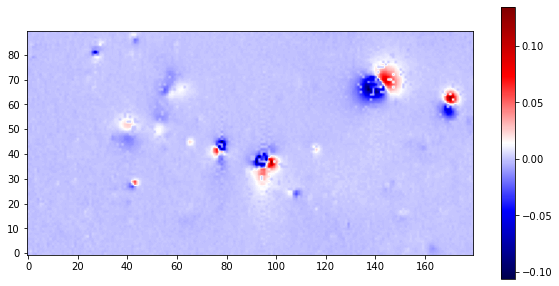

In [4]:
df = np.loadtxt('loess_3.csv', delimiter=';', skiprows=1)

df = df[60:150, 120:300]

print(np.shape(df))
plt.figure(figsize=(10,5))
plt.imshow(df, cmap='seismic')
plt.colorbar()
plt.gca().invert_yaxis()


# plt.vlines(120, 60, 150)
# plt.vlines(300, 60, 150)
# plt.hlines(150, 120, 300)
# plt.hlines(60 , 120, 300)

In [233]:
d = np.reshape(df, (np.size(df),1))
d_ = np.reshape(d, np.shape(df))

step = 4.7*microm2m

voo = 5.0
area = (0, (np.shape(df)[0])*microm2m, 0, (np.shape(df)[1])*microm2m)
shape = np.shape(df)
z = -voo*microm2m

f = np.matrix(regular(area, shape, z))
X = np.array(f[0])
Y = np.array(f[1])
Z = np.array(f[2])

cm = 10**(-7) # H/m  == T·m/A


print(f)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  9.00000000e-05
   9.00000000e-05  9.00000000e-05]
 [ 0.00000000e+00  1.00558659e-06  2.01117318e-06 ...  1.77988827e-04
   1.78994413e-04  1.80000000e-04]
 [-5.00000000e-06 -5.00000000e-06 -5.00000000e-06 ... -5.00000000e-06
  -5.00000000e-06 -5.00000000e-06]]


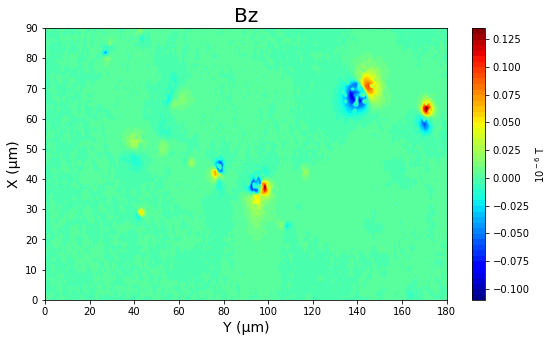

In [234]:
xs = np.linspace(area[0], area[1], shape[0])
ys = np.linspace(area[2], area[3], shape[1])

x_plot = np.reshape(Y,(np.size(xs),np.size(ys)))*m2microm
y_plot = np.reshape(X,(np.size(xs),np.size(ys)))*m2microm

# plot do mapa de dados do modelo direto

plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, d_, levels=50, cmap='jet')
plt.colorbar(label='10$^-$$^6$ T')

plt.title('Bz', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)


plt.show()

In [235]:
X_ = np.reshape(X, shape)
Y_ = np.reshape(Y, shape)
Z_ = np.reshape(Z, shape)


# calculando derivadas por FFT

ddy, ky = y_derivative_fft(d_, Y_)
ddx, kx = x_derivative_fft(d_, X_)
ddz = z_derivative_fft(d_, kx, ky)

# calculando derivadas (x e y) por FD
d_X, d_Y = (derivative_fd(d_, X_,Y_))


Text(0, 0.5, 'X (µm)')

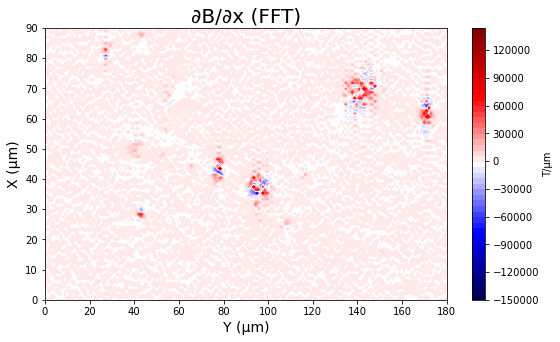

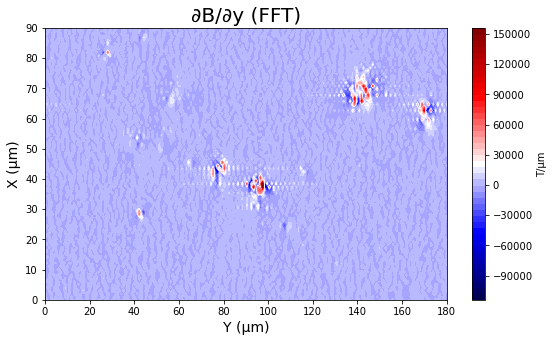

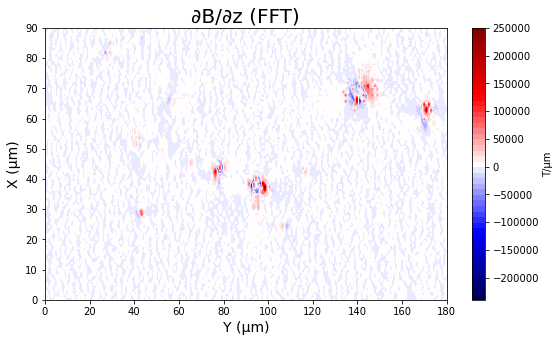

In [236]:
# plot das derivadas por FFT

plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, ddx, levels=50, cmap='seismic')
plt.colorbar(label='T/µm')

plt.title('∂B/∂x (FFT)', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)


plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, ddy, levels=50, cmap='seismic')
plt.colorbar(label='T/µm')

plt.title('∂B/∂y (FFT)', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)


plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, ddz, levels=50, cmap='seismic')
plt.colorbar(label='T/µm')

plt.title('∂B/∂z (FFT)', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)



Text(0, 0.5, 'X (µm)')

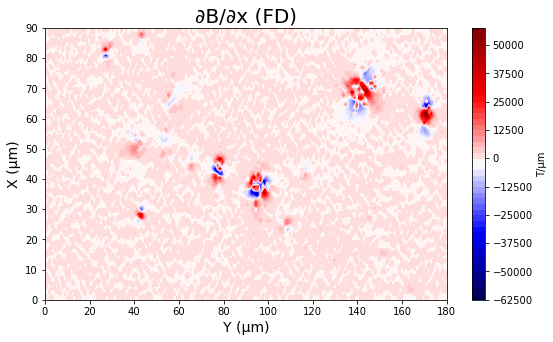

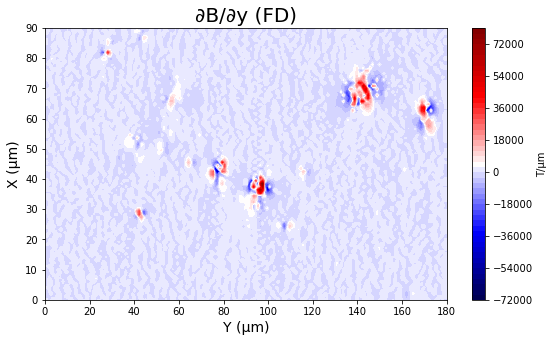

In [237]:
# plot das derivadas por FD

plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, d_X, levels=50, cmap='seismic')
plt.colorbar(label='T/µm')

plt.title('∂B/∂x (FD)', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)


plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, d_Y, levels=50, cmap='seismic')
plt.colorbar(label='T/µm')

plt.title('∂B/∂y (FD)', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)

In [238]:
# Calculo dos gradientes horizontais por FFT e FD

# calculando derivadas (x e y) por FD
d_X, d_Y = (derivative_fd(d_, X_,Y_))

Horiz_Grad_FD = Horiz_Grad(d_Y , d_X)
Horiz_Grad_FFT = Horiz_Grad(ddy, ddx)

Text(0, 0.5, 'X (µm)')

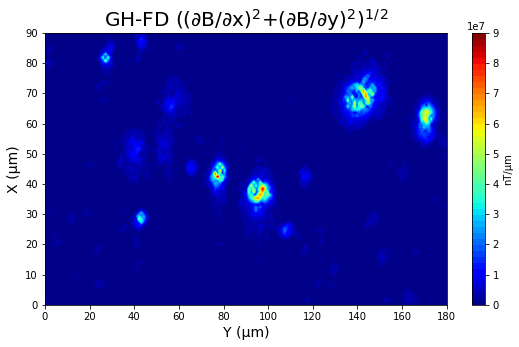

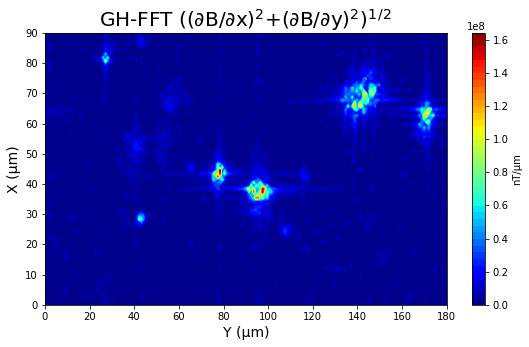

In [239]:
# Plot dos gradientes horizontais por FFT e FD

plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, Horiz_Grad_FD*10**3, levels=50, cmap='jet')
plt.colorbar(label='nT/µm')

plt.title('GH-FD'+' ((∂B/∂x)$^2$+(∂B/∂y)$^2$)$^1$$^/$$^2$', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)


plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, Horiz_Grad_FFT*10**3, levels=50, cmap='jet')
plt.colorbar(label='nT/µm')

plt.title('GH-FFT'+' ((∂B/∂x)$^2$+(∂B/∂y)$^2$)$^1$$^/$$^2$', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)


In [240]:
# Continuação p/ cima --> para remoção de ruído
altura = 0.5      # delta_z da cont p/ cima
delta_z = -altura*microm2m
upward = upward_continuation(d_, delta_z, kx, ky)

# Continuação p/ cima --> para posteriormente calcular a derivada em Z por FD
delta_z1 = -(altura-0.1)*microm2m
upward1 = upward_continuation(d_, delta_z1, kx, ky)

delta_z2 = -(altura+0.1)*microm2m
upward2 = upward_continuation(d_, delta_z2, kx, ky)

(90, 180)
(90, 180)
(90, 180)


Text(0, 0.5, 'X (µm)')

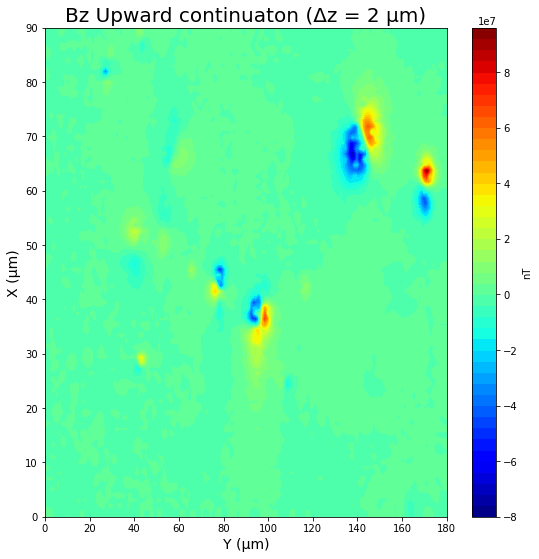

In [241]:
# Plot da Continuação p/ cima

plt.figure(figsize=(9,9))
plt.contourf(x_plot, y_plot, (upward)*10**9, levels=50, cmap='jet')
plt.colorbar(label='nT')

plt.title('Bz Upward continuaton (Δz = 2 µm)', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)


In [242]:
# New derivatives

ddy, ky = y_derivative_fft(upward, Y_)
ddx, kx = x_derivative_fft(upward, X_)

#upward_ = np.reshape(upward, (np.size(upward),1))
ddz = z_derivative_fft(upward, kx, ky)


Text(0, 0.5, 'X (µm)')

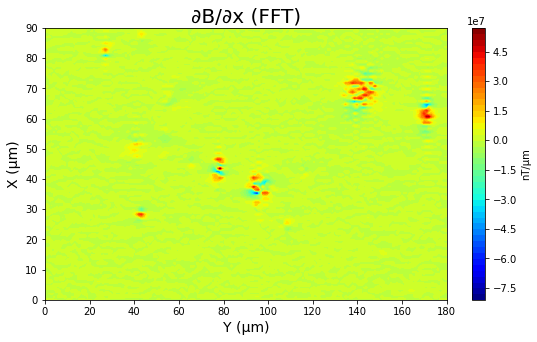

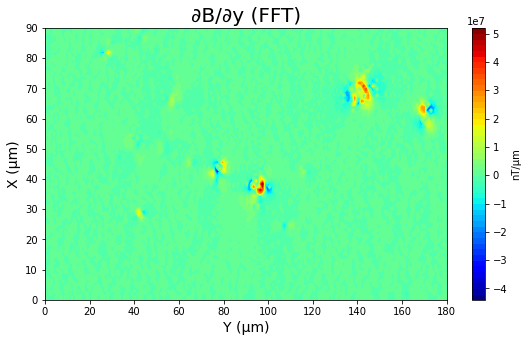

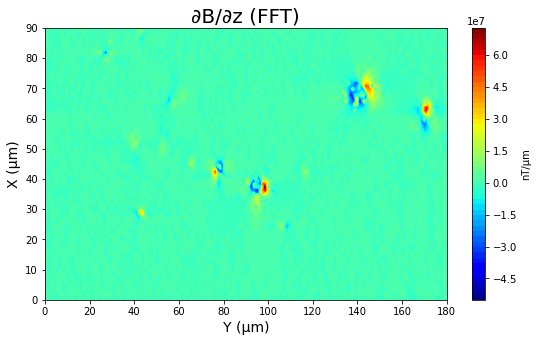

In [243]:
# Plot das Novas derivadas usando a continuação p/ cima por FFT

plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, (ddx)*10**3, levels=50, cmap='jet')
plt.colorbar(label='nT/µm')

plt.title('∂B/∂x (FFT)', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)


plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, (ddy)*10**3, levels=50, cmap='jet')
plt.colorbar(label='nT/µm')

plt.title('∂B/∂y (FFT)', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)


plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, (ddz)*10**3, levels=50, cmap='jet')
plt.colorbar(label='nT/µm')

plt.title('∂B/∂z (FFT)', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)


In [244]:
# Novas derivadas (em x e y) usando a continuação p/ cima por FD
d_X, d_Y = (derivative_fd(upward, X_,Y_))


d_Z = z_derivative_fd(upward1, upward2, delta_z1, delta_z2)


Text(0, 0.5, 'X (µm)')

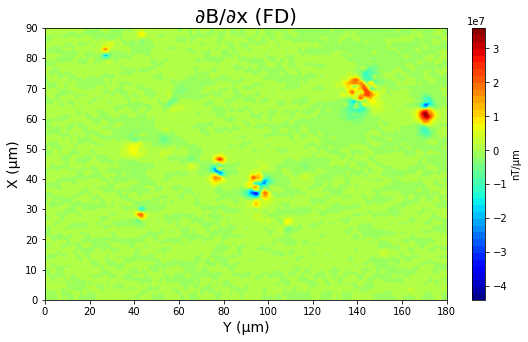

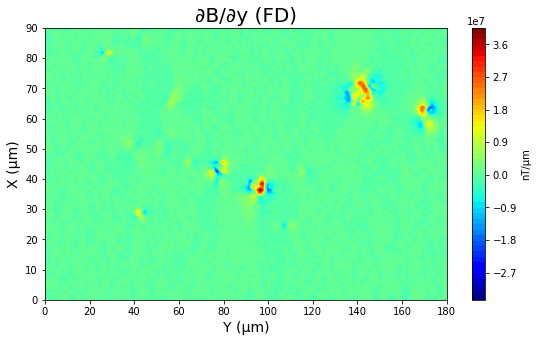

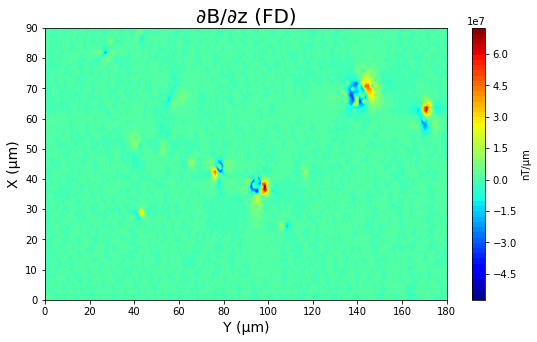

In [245]:
# Plot das novas derivadas (em x e y) usando a continuação p/ cima por FD

plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, (d_X)*10**3, levels=50, cmap='jet')
plt.colorbar(label='nT/µm')

plt.title('∂B/∂x (FD)', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)


plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, (d_Y)*10**3, levels=50, cmap='jet')
plt.colorbar(label='nT/µm')

plt.title('∂B/∂y (FD)', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)


d_Z_ = np.reshape(d_Z, (shape))

plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, d_Z_*10**3, levels=50, cmap='jet')
plt.colorbar(label='nT/µm')

plt.title('∂B/∂z (FD)', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)



In [246]:
Horiz_Grad_FD = Horiz_Grad(d_Y , d_X)
Horiz_Grad_FFT = Horiz_Grad(ddy, ddx)

# Horiz_Grad_FD = Horiz_Grad_FD/(np.log(Horiz_Grad_FD.max()) - Horiz_Grad_FD.min())
# Horiz_Grad_FFT = Horiz_Grad_FFT/(np.log(Horiz_Grad_FFT.max()) - Horiz_Grad_FFT.min())



Text(0, 0.5, 'X (µm)')

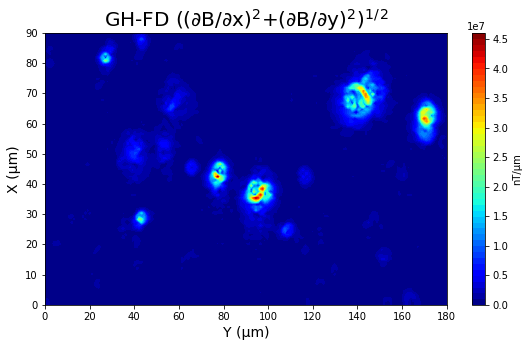

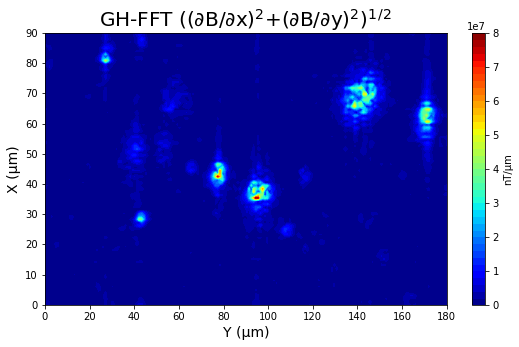

In [247]:
# Plot dos gradientes horizontais por FFT e FD

plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, Horiz_Grad_FD*10**3, levels=50, cmap='jet')
plt.colorbar(label='nT/µm')

plt.title('GH-FD'+' ((∂B/∂x)$^2$+(∂B/∂y)$^2$)$^1$$^/$$^2$', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)


plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, Horiz_Grad_FFT*10**3, levels=50, cmap='jet')
plt.colorbar(label='nT/µm')

plt.title('GH-FFT'+' ((∂B/∂x)$^2$+(∂B/∂y)$^2$)$^1$$^/$$^2$', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)

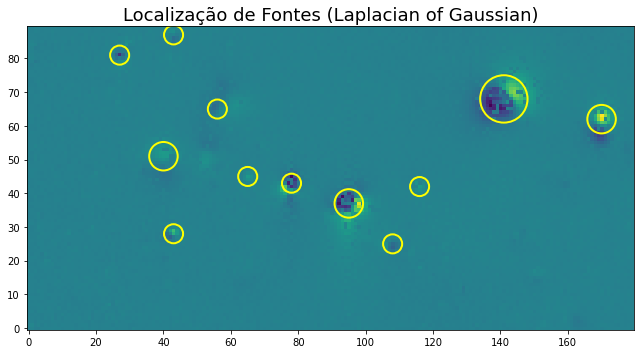

[ 43.  78.   3.  37.  95.   4.  62. 170.   4.  68. 141.   7.  28.  43.
   3.  81.  27.   3.  25. 108.   3.  51.  40.   4.  87.  43.   3.  45.
  65.   3.  65.  56.   3.  42. 116.   3.]
[4.28916922e-05 3.64989674e-05 6.21409173e-05 6.90051639e-05
 2.84907044e-05 8.12645332e-05 2.50233652e-05 5.06328511e-05
 8.79689171e-05 4.54312913e-05 6.49394642e-05 4.27136832e-05]
[7.78005091e-05 9.58940812e-05 1.70325897e-04 1.42282057e-04
 4.27050755e-05 2.72878612e-05 1.07876031e-04 3.97652073e-05
 4.31943900e-05 6.55408601e-05 5.64120843e-05 1.16533486e-04]
[-3.03366931e-06 -2.70687948e-06 -1.32672221e-06 -1.55581775e-06
 -3.20639318e-06 -2.85292409e-06 -3.09449716e-06 -5.09508918e-07
 -2.86621174e-06 -3.00472034e-06 -2.31423418e-06 -3.06010754e-06]


In [262]:
circles=sources_finder(Horiz_Grad_FFT, threshold=0.03, data=df)
print(circles)

Xc_FFT, Yc_FFT, Zc_FFT = euler_window(circles, X_, Y_, Z_, d_, ddx, ddy, ddz, structural_index = 3.0, delta_z = delta_z)

print(Xc_FFT)
print(Yc_FFT)
print(Zc_FFT)

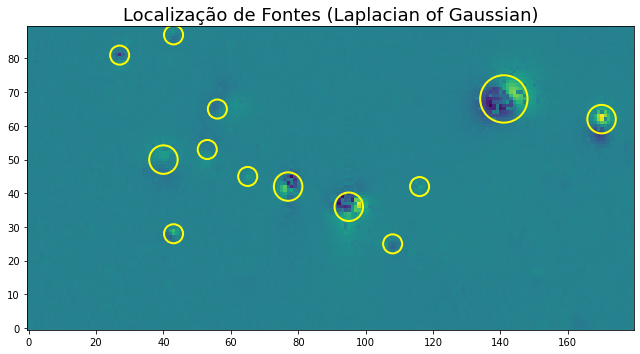

[ 62. 170.   4.  36.  95.   4.  42.  77.   4.  68. 141.   7.  28.  43.
   3.  81.  27.   3.  25. 108.   3.  50.  40.   4.  87.  43.   3.  45.
  65.   3.  65.  56.   3.  42. 116.   3.  53.  53.   3.]
[6.18036299e-05 3.61712324e-05 4.19840493e-05 6.96759592e-05
 2.84303342e-05 8.14253651e-05 2.51427974e-05 5.01902142e-05
 8.84935879e-05 4.55854063e-05 6.50306279e-05 4.29165411e-05
 5.38825053e-05]
[1.70519827e-04 9.58570004e-05 7.81571159e-05 1.41958120e-04
 4.27697553e-05 2.73482935e-05 1.07996902e-04 4.01374572e-05
 4.38149632e-05 6.57308554e-05 5.66180168e-05 1.16638884e-04
 5.45079217e-05]
[-1.48372314e-06 -2.46937301e-06 -2.80328600e-06 -1.42268553e-06
 -2.88837562e-06 -2.60219202e-06 -2.91012989e-06  1.94018896e-09
 -2.50420121e-06 -2.80681577e-06 -2.18061421e-06 -3.00253870e-06
  3.48044601e-07]


In [261]:
circles=sources_finder(Horiz_Grad_FD, threshold=0.03, data=df)
print(circles)


Xc_FD, Yc_FD, Zc_FD = euler_window(circles, X_, Y_, Z_, d_, d_X, d_Y, d_Z, structural_index = 3.0, delta_z = delta_z)

print(Xc_FD)
print(Yc_FD)
print(Zc_FD)

In [263]:
hx_FFT, hy_FFT, hz_FFT, M_FFT = least_square_solver(X, Y, Z, Xc_FFT, Yc_FFT, Zc_FFT, d)

print(hx_FFT)
print(hy_FFT)
print(hz_FFT)

[ 3.91050014e-19  5.94605262e-19 -2.98876747e-18 -2.74693848e-18
 -1.72096543e-19  2.34218925e-19 -7.23282851e-20 -1.78588962e-18
 -1.37312849e-19  1.54511477e-20  2.05227028e-19  4.85346638e-20]
[ 3.77802650e-19 -1.11392198e-18 -1.29022818e-18 -3.99182589e-18
 -1.69635092e-19 -6.66982037e-20  1.43397780e-19 -3.98221960e-20
  5.37796214e-20 -2.48518991e-20 -3.85029232e-19 -2.47161029e-20]
[-1.93737369e-19 -1.37344408e-19  1.91589217e-18 -3.20520191e-19
  1.16632265e-19 -1.75118770e-19 -7.84666167e-20  6.83696605e-19
 -7.90200821e-21  1.05166877e-19 -4.69742251e-20  8.14562836e-20]


In [264]:
hx_FD, hy_FD, hz_FD, M_FD = least_square_solver(X, Y, Z, Xc_FD, Yc_FD, Zc_FD, d)

print(hx_FD)
print(hy_FD)
print(hz_FD)

[-3.11832678e-18  8.62692761e-19  5.26091964e-19 -3.00497366e-18
 -2.33533573e-19  2.32053815e-19 -1.00227453e-19 -2.47033805e-18
 -1.66775279e-19  3.67955077e-20  2.86777238e-19  6.50960851e-20
  1.65089097e-18]
[-1.00495980e-18 -1.35494958e-18  4.19356981e-19 -4.49235085e-18
 -2.18423977e-19 -9.39521535e-20  1.57191636e-19  8.96699968e-20
  6.01408492e-20 -1.59938481e-20 -4.39791267e-19 -1.51654140e-20
  1.49898578e-19]
[ 1.55762753e-18 -9.80890180e-20 -8.87629551e-20 -2.25773187e-19
  1.53695956e-19 -2.32076167e-19 -9.66530112e-20  5.98008855e-19
  1.14467435e-20  1.27371725e-19 -2.52057814e-20  8.36389517e-20
 -2.34735753e-19]


[  44.01288893  -61.90695209 -156.65050997 -124.53344894 -135.41268733
  -15.89529084  116.76588187 -178.72261662  158.61182739  -58.12958273
  -61.94163712  -26.9873056 ]
[-19.61119164  -6.20774675  30.47822579  -3.78437007  25.76453572
 -35.71927799 -26.03855055  20.94371608  -3.06721789  74.45034006
  -6.14494974  56.23141302]

-41.73245275327164
8.941243836191601


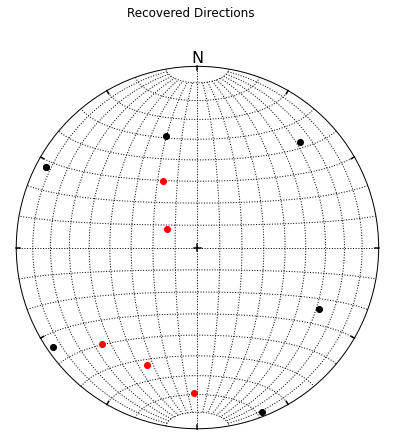

In [265]:
D_FFT, I_FFT = directions(hx_FFT, hy_FFT, hz_FFT, plot=True)

print(D_FFT)
print(I_FFT)

print()

print(np.mean(D_FFT))
print(np.mean(I_FFT))

[-162.13714923  -57.51520195   38.55895355 -123.77891834 -136.91476783
  -22.04165975  122.52211972  177.92115186  160.17018431  -23.49306687
  -56.89260255  -13.11426068    5.18814971]
[ 25.42772113  -3.49448754  -7.51588604  -2.39204169  25.67169328
 -42.83053329 -27.40455729  13.59950929   3.69422775  72.51592865
  -2.74855567  51.3702273   -8.05977061]

-7.040543696860174
7.525651943827403


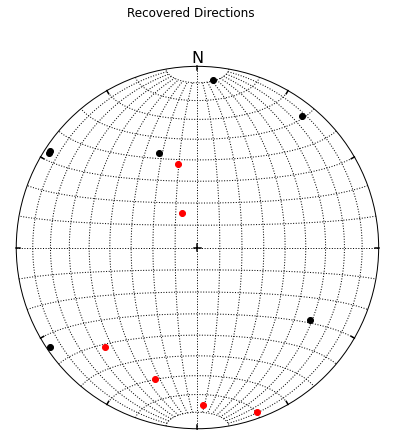

In [266]:
D_FD, I_FD = directions(hx_FD, hy_FD, hz_FD, plot=True)

print(D_FD)
print(I_FD)

print()

print(np.mean(D_FD))
print(np.mean(I_FD))

In [267]:
sigma_noise = (np.absolute(np.max(d))+np.absolute(np.min(d))) * 0.025
sigma_D_FFT, sigma_I_FFT = uncertainties(sigma_noise, M_FFT, hx_FFT, hy_FFT, hz_FFT)

print(sigma_D_FFT)
print(sigma_I_FFT)

[ 2.26801927  1.33351663  1.32732306  0.7834157   4.25031672  6.06582015
  7.23324957  3.61249928  9.99543357 43.67811583  5.29105698 22.18380969]
[ 1.60379062  0.94214537  0.90673958  0.55397301  2.96354286  4.024699
  5.0216395   2.53348989  6.98345643 11.48230309  3.74055355 11.3030961 ]


In [268]:
sigma_noise = (np.absolute(np.max(d))+np.absolute(np.min(d))) * 0.025
sigma_D_FD, sigma_I_FD = uncertainties(sigma_noise, M_FD, hx_FD, hy_FD, hz_FD)

print(sigma_D_FD)
print(sigma_I_FD)

[ 1.20846885  1.27587292  2.29372535  0.75773045  4.46082242  7.35070507
  7.50348691  3.2745848  11.59891879 38.36525708  4.87782062 19.18273392
  5.59613663]
[ 0.83968557  0.9022321   1.62472566  0.53581632  3.10003586  4.60799599
  5.17976587  2.29091707  7.99625152 11.28297017  3.43099261 10.66693247
  3.91740031]
